In [1]:
#load all the libraries 
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [2]:
import json 
import pandas as pd
import numpy as np
import math
import re
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
import nltk
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('punkt')
from difflib import SequenceMatcher

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
## load the data 
df_train=pd.read_json('/content/drive/MyDrive/Colab Notebooks/train_spider.json')
df_train


,db_id,query,query_toks,query_toks_no_value,question,question_toks,sql
0,department_management,SELECT count(*) FROM head WHERE age > 56,"[SELECT, count, (, *, ), FROM, head, WHERE, ag...","[select, count, (, *, ), from, head, where, ag...",How many heads of the departments are older th...,"[How, many, heads, of, the, departments, are, ...","{'from': {'table_units': [['table_unit', 1]], ..."
1,department_management,"SELECT name , born_state , age FROM head ORD...","[SELECT, name, ,, born_state, ,, age, FROM, he...","[select, name, ,, born_state, ,, age, from, he...","List the name, born state and age of the heads...","[List, the, name, ,, born, state, and, age, of...","{'from': {'table_units': [['table_unit', 1]], ..."
2,department_management,"SELECT creation , name , budget_in_billions ...","[SELECT, creation, ,, name, ,, budget_in_billi...","[select, creation, ,, name, ,, budget_in_billi...","List the creation year, name and budget of eac...","[List, the, creation, year, ,, name, and, budg...","{'from': {'table_units': [['table_unit', 0]], ..."
3,department_management,"SELECT max(budget_in_billions) , min(budget_i...","[SELECT, max, (, budget_in_billions, ), ,, min...","[select, max, (, budget_in_billions, ), ,, min...",What are the maximum and minimum budget of the...,"[What, are, the, maximum, and, minimum, budget...","{'from': {'table_units': [['table_unit', 0]], ..."
4,department_management,SELECT avg(num_employees) FROM department WHER...,"[SELECT, avg, (, num_employees, ), FROM, depar...","[select, avg, (, num_employees, ), from, depar...",What is the average number of employees of the...,"[What, is, the, average, number, of, employees...","{'from': {'table_units': [['table_unit', 0]], ..."
...,...,...,...,...,...,...,...
6995,culture_company,SELECT T1.company_name FROM culture_company AS...,"[SELECT, T1.company_name, FROM, culture_compan...","[select, t1, ., company_name, from, culture_co...",What are all the company names that have a boo...,"[What, are, all, the, company, names, that, ha...","{'from': {'table_units': [['table_unit', 2], [..."
6996,culture_company,"SELECT T1.title , T3.book_title FROM movie AS...","[SELECT, T1.title, ,, T3.book_title, FROM, mov...","[select, t1, ., title, ,, t3, ., book_title, f...",Show the movie titles and book titles for all ...,"[Show, the, movie, titles, and, book, titles, ...","{'from': {'table_units': [['table_unit', 1], [..."
6997,culture_company,"SELECT T1.title , T3.book_title FROM movie AS...","[SELECT, T1.title, ,, T3.book_title, FROM, mov...","[select, t1, ., title, ,, t3, ., book_title, f...",What are the titles of movies and books corres...,"[What, are, the, titles, of, movies, and, book...","{'from': {'table_units': [['table_unit', 1], [..."
6998,culture_company,SELECT T2.company_name FROM movie AS T1 JOIN c...,"[SELECT, T2.company_name, FROM, movie, AS, T1,...","[select, t2, ., company_name, from, movie, as,...",Show all company names with a movie directed i...,"[Show, all, company, names, with, a, movie, di...","{'from': {'table_units': [['table_unit', 1], [..."


# New Section

In [5]:
## renaming "query to "quer" for easy use of the column name futher in the code as "query" is a keyword.
df_train=df_train.rename(columns={"query": "quer"}) 

## only using 2 columns for training as others are not required for now.
lines= df_train[["question","quer"]] 

## reducing the  records to 2200 
lines = lines[0:2200]
print(lines.shape)
lines.sample(10)

(2200, 2)


,question,quer
1348,Find the name of the courses that do not have ...,SELECT title FROM course WHERE course_id NOT I...
600,What si the youngest employee's first and last...,"SELECT first_name , last_name FROM employees O..."
162,What is the installation date for each ending ...,"SELECT T1.id , T2.installation_date FROM trip..."
1988,Show the names of phones and the districts of ...,"SELECT T3.Name , T2.District FROM phone_marke..."
1658,Count the number of artists who are older than...,SELECT count(*) FROM artist WHERE age > 46 A...
1292,"For each injury accident, find the date of the...","SELECT T1.date , T2.player FROM game AS T1 JO..."
568,What is the number of invoices and total money...,"SELECT billing_state , COUNT(*) , SUM(total)..."
845,What is the first name and last name of the cu...,"SELECT FirstName , LastName FROM CUSTOMER WHE..."
1938,Show all the cinema names and opening years in...,"SELECT name , openning_year FROM cinema ORDER..."
1800,Find the names and total checking and savings ...,"SELECT T1.name , T2.balance + T3.balance FROM..."


In [6]:
## find out how many different special characters are used in our dataset

arry=lin=lines.to_numpy()
p = set(string.punctuation)
punList=[]
for i in arry:
  for j in i:
    for k in range(len(j)):
      if j[k] in p:
        if j[k] not in punList: 
          punList.append(j[k])
print(punList)

['?', '(', '*', ')', '>', ',', '.', '_', '!', '=', "'", ';', '%', '"', '<', '@', '/', '-', '+']


In [7]:
## replacing only those special characters with a token which are used in query and are present in the dataset
lines.question=lines.question.apply(lambda x: re.sub("'", ' sqlquote', x)).apply(lambda x: re.sub(",", ' sqlCOMMA', x))
lines.quer=lines.quer.apply(lambda x: re.sub("'", ' sqlquote', x)).apply(lambda x: re.sub(",", ' sqlCOMMA', x))
lines['quer'] = lines['quer'].str.replace('?',' sqlques')
lines['quer'] = lines['quer'].str.replace('_',' sqlunderscr')
lines['quer'] = lines['quer'].str.replace('-',' sqlminus')
lines['quer'] = lines['quer'].str.replace('/',' sqlslash')
lines['quer'] = lines['quer'].str.replace('@',' sqlat')
lines['quer'] = lines['quer'].str.replace('"',' sqldoubtquote')
lines['quer'] = lines['quer'].str.replace('%',' sqlperc')
lines['quer'] = lines['quer'].str.replace('+',' sqlplus')
lines['quer'] = lines['quer'].str.replace('!',' sqlnoteq')
lines['quer'] = lines['quer'].str.replace('=',' sqlequal')
lines['quer'] = lines['quer'].str.replace('*',' sqlstar')
lines['quer'] = lines['quer'].str.replace('(',' sqlopenbrac')
lines['quer'] = lines['quer'].str.replace(')',' sqlclosebrac')
lines['quer'] = lines['quer'].str.replace('<',' sqlopenv')
lines['quer'] = lines['quer'].str.replace('>',' sqlclosev')
lines['quer'] = lines['quer'].str.replace('.',' sqldot')

## Lower-case all the characters
lines.question=lines.question.apply(lambda x: x.lower())
lines.quer=lines.quer.apply(lambda x: x.lower())

## removing all other punctuations/ special characters
exc = set(string.punctuation)
lines.question=lines.question.apply(lambda x: ''.join(ch for ch in x if ch not in exc))
lines.quer=lines.quer.apply(lambda x: ''.join(ch for ch in x if ch not in exc))

## Remove extra spaces  ##
lines.question=lines.question.apply(lambda x: x.strip())
lines.quer=lines.quer.apply(lambda x: x.strip())
lines.question=lines.question.apply(lambda x: re.sub(" +", " ", x))
lines.quer=lines.quer.apply(lambda x: re.sub(" +", " ", x))

lines.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: The default value o

,question,quer
0,how many heads of the departments are older th...,select count sqlopenbrac sqlstar sqlclosebrac ...
1,list the name sqlcomma born state and age of t...,select name sqlcomma born sqlunderscrstate sql...
2,list the creation year sqlcomma name and budge...,select creation sqlcomma name sqlcomma budget ...
3,what are the maximum and minimum budget of the...,select max sqlopenbracbudget sqlunderscrin sql...
4,what is the average number of employees of the...,select avg sqlopenbracnum sqlunderscremployees...


In [8]:
##  Add 'START_' token and '_END' token to target sequences  ##
lines.quer = lines.quer.apply(lambda x : 'START_ '+ x + ' _END')





In [9]:
## Vocabulary of question  ##
all_question_words=set()
for qus in lines.question:
    for word in qus.split():
        if word not in all_question_words:
            all_question_words.add(word)

## Vocabulary of query  ##
all_query_words=set()
for qur in lines.quer:
    for word in qur.split():
        if word not in all_query_words:
            all_query_words.add(word)
            
len(all_question_words), len(all_query_words)

(1545, 1406)

In [10]:
## Maximum Length of source/input sequence  ##
lenght_list=[]
for l in lines.quer:
    lenght_list.append(len(l.split(' ')))
max_length_src = np.max(lenght_list)
max_length_src

91

In [11]:
## Maximum Length of target/output sequence ##
lenght_list=[]
for l in lines.question:
    lenght_list.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list)+64
max_length_tar

104

In [12]:
inp_words = sorted(list(all_question_words))
targ_words = sorted(list(all_query_words))

##  Calculate Vocabulary size of source and target sequence  ##
num_encoder_tokens = len(all_question_words)+1
num_decoder_tokens = len(all_query_words)+1

num_encoder_tokens, num_decoder_tokens


(1546, 1407)

In [13]:
num_decoder_tokens += 1 # For zero padding #
num_decoder_tokens

1408

In [14]:
## Make a word-to-token dictionary for both target and source ##
inp_token_index = dict([(word, i+1) for i, word in enumerate(inp_words)])
targ_token_index = dict([(word, i+1) for i, word in enumerate(targ_words)])


In [15]:
## Make a token-to-word dictionary for both target and source ##
reverse_inp_char_index = dict((i, word) for word, i in inp_token_index.items())
reverse_targ_char_index = dict((i, word) for word, i in targ_token_index.items())

lines = shuffle(lines)
lines.head(10)


,question,quer
51,which statuses correspond to both cities that ...,START_ select status from city where populatio...
1087,count the number of different colleges that pl...,START_ select count sqlopenbracdistinct t1 sql...
574,what is the company where eduardo martins is a...,START_ select company from customers where fir...
509,how many female students have milk or egg alle...,START_ select count sqlopenbrac sqlstar sqlclo...
418,what are the names for all aircrafts with at l...,START_ select t2 sqldotname from flight as t1 ...
1672,what are the names of artists that have not ha...,START_ select name from artist where artist sq...
1914,show the number of buildings with a height abo...,START_ select count sqlopenbrac sqlstar sqlclo...
32,list the official name and status of the city ...,START_ select official sqlunderscrname sqlcomm...
1007,find how many different affiliation types ther...,START_ select count sqlopenbracdistinct affili...
276,how many users are there,START_ select count sqlopenbrac sqlstar sqlclo...


In [16]:
## Train - Test - validation Split ##

lines_val=lines[2000:]  # storing a subset of data for validation #
lines=lines[0:2000]     # storing rest data for testing and training #
X, y = lines.question, lines.quer
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)   # 90% for training and 10% for testing
X_train.shape, X_test.shape
lines_val.shape

(200, 2)

In [17]:
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')
def generate_batch(X = X_train, y = y_train, batch_size = 64):
##  ''' Generate a data batch ''' ##
    while True:
        for j in range(0, len(X), batch_size):
            encoder_inp_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_inp_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_targ_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (inp_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):                
                for t, word in enumerate(inp_text.split()):
                    encoder_inp_data[i, t] = inp_token_index[word] # encoder input sequenc
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_inp_data[i, t] = targ_token_index[word] # decoder input sequenc
                    if t>0:
                        ## START_ token is not included
                        ## decoder target sequence (one hot encoded)
                        ## Offset by one timestep
                        decoder_targ_data[i, t - 1, targ_token_index[word]] = 1.
            yield([encoder_inp_data, decoder_inp_data], decoder_targ_data)

In [18]:
latent_dim = 256

In [19]:
##  Encoder  ##
encoder_inp = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inp)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

##  Only the states are kept, and the encoder_outputs are discarded.  ##
encoder_states = [state_h, state_c]

In [20]:
##  Set the initial state of the decoder to 'encoder_states'  ##
decoder_inp = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inp)

##  We configured our decoder to return complete output sequences as well as internal states.  ##
##  The return states aren't used in the training model, but they will be used in inference.   ##
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_out, _, _ = decoder_lstm(dec_emb,initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_out = decoder_dense(decoder_out)

##  Define the model that will turn `encoder_inp_data` & `decoder_inp_data` into `decoder_targ_data`  ##
model = Model([encoder_inp, decoder_inp], decoder_out)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


In [21]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 64
epochs =90

print(train_samples//batch_size)
print(val_samples//batch_size)

model.summary()


28
3
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 256)    395776      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    360448      ['input_2[0][0]']                
                                                                                         

In [22]:
his= model.fit(generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = (val_samples//batch_size))

Epoch 1/90
28/28 [==============================] - 65s 2s/step - loss: 1.0756 - accuracy: 0.1226 - val_loss: 0.9461 - val_accuracy: 0.1468
Epoch 2/90
28/28 [==============================] - 51s 2s/step - loss: 0.9020 - accuracy: 0.1929 - val_loss: 0.8728 - val_accuracy: 0.2409
Epoch 3/90
28/28 [==============================] - 51s 2s/step - loss: 0.8136 - accuracy: 0.2858 - val_loss: 0.7697 - val_accuracy: 0.3356
Epoch 4/90
28/28 [==============================] - 51s 2s/step - loss: 0.6997 - accuracy: 0.3975 - val_loss: 0.6614 - val_accuracy: 0.4369
Epoch 5/90
28/28 [==============================] - 52s 2s/step - loss: 0.6061 - accuracy: 0.4617 - val_loss: 0.5863 - val_accuracy: 0.4756
Epoch 6/90
28/28 [==============================] - 52s 2s/step - loss: 0.5342 - accuracy: 0.5008 - val_loss: 0.5214 - val_accuracy: 0.5197
Epoch 7/90
28/28 [==============================] - 51s 2s/step - loss: 0.4848 - accuracy: 0.5317 - val_loss: 0.4792 - val_accuracy: 0.5510
Epoch 8/90
28/28 [==

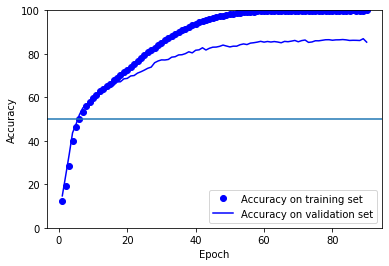

In [23]:
##  plot the training and testing accuracy  ##
import matplotlib.pyplot as plt
def plot_history_classif(hist):
  n_ = len(hist.history['accuracy'])
  plt.plot(range(1, n_+1), 100*np.asarray(hist.history['accuracy']), 'bo', label='Accuracy on training set')
  plt.plot(range(1, n_+1), 100*np.asarray(hist.history['val_accuracy']), 'b', label='Accuracy on validation set')
  plt.legend()
  plt.xlabel("Epoch") 
  plt.ylabel("Accuracy")
  plt.ylim(0, 100)
  plt.axhline(y=50)
  plt.show()
plot_history_classif(his)


In [24]:
##  input sequence are encoded to get the "thought vectors"  ##
encoder_model = Model(encoder_inp, encoder_states)

##  Decoder setup  ##
##  The states from the previous time step will be held by the tensors below.  ##
decoder_state_inp_h = Input(shape=(latent_dim,))
decoder_state_inp_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_inp_h, decoder_state_inp_c]

dec_emb2= dec_emb_layer(decoder_inp) # Get the embeddings of the decoder sequence

##  To predict the next word in the sequence, set the initial states to the states from the previous time step  ##
decoder_out2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_out2 = decoder_dense(decoder_out2) # A dense softmax layer to generate prob dist. over the target vocabulary  ##

##  Final decoder model
decoder_model = Model(
    [decoder_inp] + decoder_states_inputs,
    [decoder_out2] + decoder_states2)

In [25]:
def decode_sequence(inp_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(inp_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = targ_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_targ_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 500):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [36]:
X_val, y_val = lines_val.question, lines_val.quer
train_gen = generate_batch(X_val, y_val, batch_size = 1)
k=-1


In [37]:
k+=1
## converting token to its respective special characters  ##
def rev(str):
  str=str.replace(' sqlquote',"'")
  str=str.replace(' sqlcomma',",")
  str=str.replace(' sqlequal',"=")
  str=str.replace(' sqlstar',"*")
  str=str.replace(' sqlopenbrac',"(")
  str=str.replace(' sqlclosebrac',")")
  str=str.replace(' sqlopenv',"<")
  str=str.replace(' sqlclosev',">")
  str=str.replace(' sqldot',".")
  str=str.replace(' sqlques',"?")
  str=str.replace(' sqlunderscr',"_")
  str=str.replace(' sqlminus',"-")
  str=str.replace(' sqlslash',"/")
  str=str.replace(' sqlat',"@")
  str=str.replace(' sqldoubtquote','"')
  str=str.replace(' sqlperc',"%")
  str=str.replace(' sqlplus',"+")
  str=str.replace(' sqlnoteq',"!")
  return str

(inp_seq, actual_output), _ = next(train_gen)

decoded_sentence = rev(decode_sequence(inp_seq))
In_Question= rev(X_val[k:k+1].values[0])
Act_Quer= rev(y_val[k:k+1].values[0][6:-4])

print('Input question sentence:', In_Question)
print('Actual query Translation:',Act_Quer)
print('Predicted query Translation:', decoded_sentence[:-4])


Input question sentence: show the average, minimum, and maximum ticket prices for exhibitions for all years before 2009
Actual query Translation:  select avg(ticket_price), min(ticket_price), max(ticket_price) from exhibition where year< 2009 
Predicted query Translation:  select avg(ticket_price), min(ticket_price), max(ticket_price) from exhibition where year< 2009 


In [33]:
## evaluate validation data set
sum=0
for k in range(len(X_val)):
  sum=sum+SequenceMatcher(a=rev(y_val[k:k+1].values[0][6:-4]), b=rev(decode_sequence(inp_seq))[:-4]).ratio()
avg=sum/len(X_val)
print("similarity % of predected and actual queries on validation dataset  = ",avg*100)


similarity % of predected and actual queries on validation dataset  =  34.748466658290155


In [38]:
## evaluate testing data set
train_gen = generate_batch(X_test, y_test, batch_size = 1)
(inp_seq, actual_output), _ = next(train_gen)
sum=0
for k in range(len(X_test)):
  sum=sum+SequenceMatcher(a=rev(y_test[k:k+1].values[0][6:-4]), b=rev(decode_sequence(inp_seq))[:-4]).ratio()
avg=sum/len(X_test)
print("similarity % of predected and actual queries on testing dataset  = ",avg*100)

similarity % of predected and actual queries on testing dataset  =  35.8942448270029


In [44]:
## evaluate training dataset on only 200 records
train_gen = generate_batch(X_train, y_train, batch_size = 1)
(inp_seq, actual_output), _ = next(train_gen)
sum=0
for k in range(200):
  sum=sum+SequenceMatcher(a=rev(y_train[k:k+1].values[0][6:-4]), b=rev(decode_sequence(inp_seq))[:-4]).ratio()
avg=sum/200
print("similarity % of predected and actual queries on training dataset  = ",avg*100)

similarity % of predected and actual queries on training dataset  =  39.23307445296522
